# 01. PlayingNumbers/ds_salary_proj

## Predictions with ML Regression Models - salary_data_cleaned.csv

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('01_salary_data_cleaned.csv')

In [3]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\r\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\r\n,MD,0,36,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\r\n,FL,1,10,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\r\n,WA,1,55,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\r\n,NY,1,22,1,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          742 non-null    object 
 1   Salary Estimate    742 non-null    object 
 2   Job Description    742 non-null    object 
 3   Rating             742 non-null    float64
 4   Company Name       742 non-null    object 
 5   Location           742 non-null    object 
 6   Headquarters       742 non-null    object 
 7   Size               742 non-null    object 
 8   Founded            742 non-null    int64  
 9   Type of ownership  742 non-null    object 
 10  Industry           742 non-null    object 
 11  Sector             742 non-null    object 
 12  Revenue            742 non-null    object 
 13  Competitors        742 non-null    object 
 14  hourly             742 non-null    int64  
 15  employer_provided  742 non-null    int64  
 16  min_salary         742 non

## Preprocessing

All preprocessing steps are done in almost exactly the same way as the author...

In [5]:
def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'
    
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr' in title.lower() \
        or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower():
        return 'jr'
    else:
        return 'na'

In [6]:
# Simplify the job titles
df['job_simp'] = df['Job Title'].apply(title_simplifier)
df['job_simp'].value_counts()

data scientist    279
na                184
data engineer     119
analyst           102
manager            22
mle                22
director           14
Name: job_simp, dtype: int64

In [7]:
# Simplify seniorities
df['seniority'] = df['Job Title'].apply(seniority)
df.seniority.value_counts()

na        520
senior    220
jr          2
Name: seniority, dtype: int64

In [8]:
# Fix state Los Angeles and make it count as 'CA'
df['job_state'] = df['job_state'].apply(lambda x: x.strip() if x.strip().lower() != 'los angeles' else 'CA')
df.job_state.value_counts()

CA    152
MA    103
NY     72
VA     41
IL     40
MD     35
PA     33
TX     28
NC     21
WA     21
NJ     17
FL     16
OH     14
TN     13
DC     11
CO     11
WI     10
UT     10
IN     10
AZ      9
MO      9
AL      8
GA      6
DE      6
KY      6
MI      6
CT      5
IA      5
LA      4
OR      4
NE      4
NM      3
KS      3
ID      2
MN      2
RI      1
SC      1
Name: job_state, dtype: int64

In [9]:
# Get the length of all job descriptions
df['desc_len'] = df['Job Description'].apply(lambda x: len(x))
df['desc_len']

0      2555
1      4828
2      3495
3      3926
4      2748
       ... 
737    6219
738    6167
739    3107
740    1678
741    3710
Name: desc_len, Length: 742, dtype: int64

In [10]:
# Get the competitor counts for all jobs
df['num_comp'] = df['Competitors'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)
df['num_comp'].value_counts()

0    460
3    228
2     41
1     12
4      1
Name: num_comp, dtype: int64

In [11]:
# Convert hourly wage to annual (there are 24 jobs marked as hourly)
df['min_salary'] = df.apply(lambda x: x.min_salary * 2 if x.hourly == 1 else x.min_salary, axis=1)
df['max_salary'] = df.apply(lambda x: x.max_salary * 2 if x.hourly == 1 else x.max_salary, axis=1)
df[df['hourly'] == 1][['hourly','min_salary','max_salary','avg_salary']]

,hourly,min_salary,max_salary,avg_salary
165,1,34,48,20.5
177,1,42,68,27.5
197,1,36,50,21.5
202,1,42,68,27.5
210,1,30,50,20.0
246,1,34,48,20.5
271,1,42,68,27.5
337,1,36,50,21.5
345,1,48,78,31.5
357,1,42,68,27.5


In [12]:
# Get rid of the backslash characters in all company texts
df['company_txt'] = df['company_txt'].apply(lambda x: x.replace('\n', ''))
df['company_txt'] = df['company_txt'].apply(lambda x: x.replace('\r', ''))
df['company_txt']

0                          Tecolote Research
1      University of Maryland Medical System
2                                    KnowBe4
3                                       PNNL
4                         Affinity Solutions
                       ...                  
737                                      GSK
738                               Eventbrite
739           Software Engineering Institute
740                             Numeric, LLC
741             Riverside Research Institute
Name: company_txt, Length: 742, dtype: object

In [13]:
# Get the average of company ratings and ages to replace those with -1 values
rating_avg = round(df[df['Rating'] != -1.0]['Rating'].mean(), 2)
age_avg = round(df[df['age'] != -1]['age'].mean(), 2)
df['Rating'] = df['Rating'].apply(lambda x: rating_avg if x == -1.0 else x)
df['age'] = df['age'].apply(lambda x: age_avg if x == -1 else x)

In [14]:
# Now is the time to reveal the statistics of all numerical columns
df.describe()

,Rating,Founded,hourly,employer_provided,min_salary,max_salary,avg_salary,same_state,age,python_yn,R_yn,spark,aws,excel,desc_len,num_comp
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.688396,1837.154987,0.032345,0.022911,74.719677,128.149596,100.626011,0.557951,50.030323,0.528302,0.002695,0.225067,0.237197,0.522911,3910.172507,1.053908
std,0.566104,497.183763,0.177034,0.149721,30.980593,45.220324,38.855948,0.496965,52.233003,0.499535,0.051882,0.417908,0.425651,0.499812,1533.827777,1.384239
min,1.900000,-1.000000,0.000000,0.000000,15.000000,16.000000,13.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000
25%,3.300000,1939.000000,0.000000,0.000000,52.000000,96.000000,73.500000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2834.000000,0.000000
50%,3.700000,1988.000000,0.000000,0.000000,69.500000,124.000000,97.500000,1.000000,32.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3781.500000,0.000000
75%,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,1.000000,59.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4772.000000,3.000000
max,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,1.000000,276.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10146.000000,4.000000


In [15]:
# All columns in the dataset right now
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

## Prepare Train and Test Sets

In [17]:
# Create dummies of all categorized columns and merge them with numericals
dummy_job_simp = pd.get_dummies(df['job_simp'])
dummy_seniority = pd.get_dummies(df['seniority'])
dummy_job_state = pd.get_dummies(df['job_state'])
df_numeric = df[['Rating','hourly','employer_provided','same_state','age',
                 'python_yn','R_yn','spark','aws','excel','desc_len','num_comp']]
df_cons = pd.concat([dummy_job_simp, dummy_seniority, dummy_job_state, df_numeric, df['avg_salary']], axis=1)
df_cons

,analyst,data engineer,data scientist,director,manager,mle,na,jr,na,senior,...,same_state,age,python_yn,R_yn,spark,aws,excel,desc_len,num_comp,avg_salary
0,0,0,1,0,0,0,0,0,1,0,...,0,47.00,1,0,0,0,1,2555,0,72.0
1,0,0,1,0,0,0,0,0,1,0,...,0,36.00,1,0,0,0,0,4828,0,87.5
2,0,0,1,0,0,0,0,0,1,0,...,1,10.00,1,0,1,0,1,3495,0,85.0
3,0,0,1,0,0,0,0,0,1,0,...,1,55.00,1,0,0,0,0,3926,3,76.5
4,0,0,1,0,0,0,0,0,1,0,...,1,22.00,1,0,0,0,1,2748,3,114.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,0,0,0,0,0,0,1,0,0,1,...,0,190.00,0,0,0,1,0,6219,3,84.5
738,0,1,0,0,0,0,0,0,0,1,...,0,14.00,1,0,1,1,0,6167,3,102.5
739,0,0,0,0,0,0,1,0,1,0,...,1,36.00,0,0,0,0,1,3107,0,73.5
740,0,0,0,0,1,0,0,0,1,0,...,0,50.03,0,0,0,0,1,1678,0,127.5


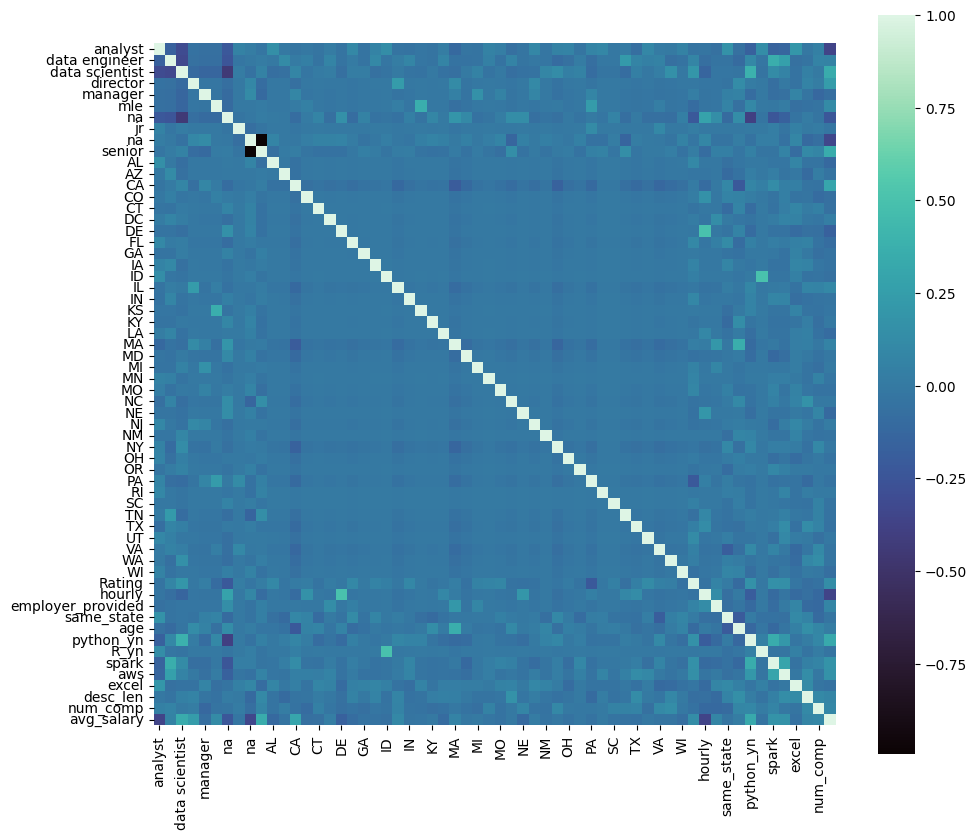

#### CORRELATION VALUES AGAINST AVERAGE SALARIES ####
analyst             -0.357460
data engineer        0.053771
data scientist       0.338627
director             0.242785
manager             -0.074744
mle                  0.116171
na                  -0.233257
jr                  -0.025607
na                  -0.346247
senior               0.350057
AL                  -0.114774
AZ                  -0.042689
CA                   0.299173
CO                  -0.074495
CT                  -0.062631
DC                   0.030188
DE                  -0.170037
FL                  -0.087937
GA                  -0.046411
IA                  -0.046086
ID                  -0.059413
IL                   0.098584
IN                  -0.031082
KS                  -0.022358
KY                  -0.008431
LA                  -0.091721
MA                   0.058476
MD                  -0.018731
MI                  -0.000874
MN                  -0.020252
MO                  -0.045384
NC              

In [23]:
# Show the correlations in a heat map
plt.figure(figsize=(11,12))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(df_cons.corr(), center=0, cmap='mako', square=True, cbar_kws={"shrink": .8}, annot_kws={'fontsize': 8})
plt.show()
print("#### CORRELATION VALUES AGAINST AVERAGE SALARIES ####")
print(df_cons.corr()['avg_salary'])

In [18]:
# Use 80% of the dataset as training, and 20% as testing
X = df_cons.drop(columns='avg_salary', axis=1)
Y = df_cons.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, " TEST SIZE:", x_test.shape)

TRAIN SIZE: (593, 59)  TEST SIZE: (149, 59)


In [19]:
# Create lists to store results of error values of all regression methods
res_mse, res_rmse, res_mae, res_r2, res_cv_train, res_cv_test = [], [], [], [], [], []

# ML Regression Models

## 1 - Linear Regression

In [216]:
linreg = LinearRegression(fit_intercept=True, positive=False)
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [217]:
# Fit the training data into the linear reg. model, then make predictions on the test data
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

In [218]:
print("COEF:", linreg.coef_)   # Estimated coefficients for the linear reg.
print("RANK:", linreg.rank_)   # Rank of matrix
print("INTERCEPT:", linreg.intercept_)   # Independent term in the linear model

COEF: [-3.74761335e+01 -4.65046697e+00  8.63689494e-01  6.52675960e+01
 -2.63967871e+01  2.06172528e+01 -1.82251508e+01 -9.65489305e+00
 -8.62598477e+00  1.82808778e+01 -7.77946431e+00 -1.10724081e+01
  3.05029943e+01  1.52375045e-01 -1.11282779e+01  6.77859478e+00
  5.30900801e+00 -8.76835390e+00 -1.44747668e+01 -4.81910632e+00
  1.58791532e+01  9.55987105e+00 -6.82407278e-01 -2.97926301e+01
  1.21912569e+01 -7.92650085e+00  7.51491895e+00  1.18124585e+01
  2.02529623e+00  9.05823960e+00  5.00253875e+00 -3.27226356e+00
 -6.07217826e+00  1.66429755e+01 -2.54469625e+01  5.77757648e+00
  4.26607350e+00 -4.88180203e+00  6.60727507e+00  2.26745601e+01
 -1.64248979e+01 -1.38225092e+01  8.63847404e-01  7.42947701e+00
 -9.00843003e-01 -7.00317327e+00 -5.77994516e+00  3.69778097e+00
 -4.60606228e+01  3.35730926e+01 -3.42252600e+00  4.34679037e-02
  8.01605869e+00 -2.59800602e+01  2.96867083e+00  1.54639145e+00
  1.53570682e+00  6.22016583e-04  1.53835806e+00]
RANK: 56
INTERCEPT: 77.71785727872

In [219]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  147.10451558077227 |    181.0
   59.28323912949179 |     26.5
   132.4248499469528 |    107.0
   89.00744026328148 |    118.5
   41.20005999084978 |     44.5
  53.263562384052385 |     60.0
  169.22499218904278 |    179.5
  113.37449176663463 |    115.0
  128.10744008825787 |    100.0
   96.01199511281709 |    129.5
   96.92084364834466 |     64.5
   99.13441504726967 |     65.5
    79.2732126447564 |     93.5
  109.89946293733482 |     92.5
   67.95772355799782 |     99.5
  109.77754661258587 |    112.5
   56.50997990894251 |     65.0
   134.3517639405019 |    124.0
  101.21717086720318 |    134.5
   135.6777460410338 |    237.5


In [220]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-linreg.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)         # Mean squared error
print("RMSE:", rmse)       # Root mean squared error
print("MAE:", mae)         # Mean absolute error
print("R2 SCORE:", r2)     # R2 score
print("ADJUSTED R2 SCORE:", adj_r2)   # Adjusted R2 score
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(linreg, X, Y, cv=5, return_train_score=True)    # 5-fold Cross Validation
# The time in seconds for fitting the estimator on the train set for each cv split
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
# The time in seconds for scoring the estimator on the test set for each cv split
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
# The score array for train scores for each cv split
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
# The score array for test score for each cv split
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 679.9375084045932
RMSE: 26.07561137163601
MAE: 20.768941464503516
R2 SCORE: 0.5183108721768981
ADJUSTED R2 SCORE: 0.5806806192322314

# CROSS VALIDATION #
FITTING TIME: [0.01530933 0.0121088  0.01253176 0.01302528 0.0115087 ] -> 0.01289677619934082
SCORING TIME: [0.00201845 0.00203276 0.00152898 0.00101542 0.00200057] -> 0.0017192363739013672
TRAIN SCORE: [0.6379214  0.59609677 0.62271175 0.62420036 0.65391916] -> 0.6269698897077722
TEST SCORE: [0.46190047 0.65135738 0.5817575  0.59254004 0.44615817] -> 0.5467427114601675


## 2 - Lasso Regression

In [221]:
lasso = Lasso(alpha=1.0, fit_intercept=True, positive=False, tol=0.0001, selection='cyclic')
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [222]:
# Fit the training data into the lasso model, then make predictions on the test data
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)

In [223]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
print("ITERATIONS:", lasso.n_iter_)   # Number of iterations run by the coord. descent solver to reach the specified tolerance

COEF: [-2.65523187e+01  0.00000000e+00  4.31480480e+00  1.84523876e+01
 -0.00000000e+00  0.00000000e+00 -1.12128370e+01 -0.00000000e+00
 -0.00000000e+00  2.27390493e+01 -0.00000000e+00 -0.00000000e+00
  2.19281480e+01 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  2.60477830e-01
 -2.02903948e+01  0.00000000e+00 -0.00000000e+00  5.87178544e-02
  1.09426630e+01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  7.59675508e-04  1.41040666e+00]
INTERCEPT: 79.39971072125587
ITERA

In [224]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  118.41798971455088 |    181.0
   52.75719593107593 |     26.5
  130.15518621177046 |    107.0
    94.0027830232411 |    118.5
   59.28322629077266 |     44.5
   70.02875932140446 |     60.0
  117.41833158828891 |    179.5
  112.69604116637018 |    115.0
  125.35228344091672 |    100.0
   93.53901866439165 |    129.5
    98.6516867849623 |     64.5
   101.6550825847374 |     65.5
   73.83642978646581 |     93.5
  103.52128411430549 |     92.5
   82.98494466309666 |     99.5
  102.03156054443497 |    112.5
   61.02377827492765 |     65.0
  109.04804607385648 |    124.0
   95.87424197004307 |    134.5
   130.2368740591902 |    237.5


In [225]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-lasso.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)        
print("R2 SCORE:", r2)
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 828.4769923204815
RMSE: 28.783276261059676
MAE: 23.40807242516331
R2 SCORE: 0.41308082740025
ADJUSTED R2 SCORE: 0.4403244508168751

# CROSS VALIDATION #
FITTING TIME: [0.00650978 0.00552869 0.00604939 0.00568032 0.00456309] -> 0.005666255950927734
SCORING TIME: [0.00301647 0.00298429 0.00198197 0.00103521 0.00153422] -> 0.0021104335784912108
TRAIN SCORE: [0.52409118 0.45622454 0.47618556 0.49148944 0.49690886] -> 0.48897991728531787
TEST SCORE: [0.36933757 0.55213828 0.41244153 0.49664957 0.33625983] -> 0.4333653559606619


## 3 - Ridge Regression

In [226]:
ridge = Ridge(alpha=1.0, fit_intercept=True, positive=True, tol=0.0001, solver='auto')
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': True,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [227]:
# Fit the training data into the ridge model, then make predictions on the test data
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [228]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [0.00000000e+00 1.04308029e-06 5.39924282e-06 1.12850332e-06
 0.00000000e+00 6.62795965e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.55885185e-06 0.00000000e+00 0.00000000e+00
 4.61153206e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.02409519e-07 2.48133363e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.77839648e-07 0.00000000e+00
 1.46218015e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.26984995e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.30753637e-06
 0.00000000e+00 5.72573834e-07 0.00000000e+00 1.26965357e-05
 6.03251510e-06 0.00000000e+00 2.71701743e-06 2.30737103e-06
 0.00000000e+00 2.05364482e-03 4.27431464e-06]
INTERCEPT: 91.77787248144757
ITERATIONS: None


In [229]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   95.96134360143965 |    181.0
   95.61054112366328 |     26.5
  101.74390061917396 |    107.0
   98.87327082282891 |    118.5
  100.27433180219754 |     44.5
  100.30242685317111 |     60.0
   97.79419530013647 |    179.5
  101.57989169900829 |    115.0
   107.8870224553937 |    100.0
  101.37261308016159 |    129.5
   97.85074563778184 |     64.5
    96.4753736683707 |     65.5
   101.3768461259988 |     93.5
  108.65304819327412 |     92.5
  106.58444612148344 |     99.5
  105.06940256355568 |    112.5
    96.9101810094806 |     65.0
  102.91115033337331 |    124.0
  100.94544811214783 |    134.5
   98.60325292057415 |    237.5


In [230]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-ridge.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 1420.2748838288576
RMSE: 37.686534516042435
MAE: 30.09738878842735
R2 SCORE: -0.006167422158877667
ADJUSTED R2 SCORE: -0.08037454622527984

# CROSS VALIDATION #
FITTING TIME: [0.01425815 0.01220512 0.00900674 0.00776935 0.00397825] -> 0.009443521499633789
SCORING TIME: [0.00149465 0.00199938 0.00155544 0.00203848 0.00182748] -> 0.0017830848693847657
TRAIN SCORE: [0.37791108 0.3945668  0.24368643 0.23847755 0.00308879] -> 0.2515461290774856
TEST SCORE: [0.20584996 0.57469989 0.19814021 0.24443538 0.01033325] -> 0.24669173735156366


## 4 - Polynomial Regression

In [231]:
poly_feat = PolynomialFeatures(degree=2, include_bias=True, interaction_only=True, order='C')
poly_feat.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': True, 'order': 'C'}

In [232]:
# Fit then transform for both training and test data (the number of columns must increase)
x_poly_train = poly_feat.fit_transform(x_train)
x_poly_test = poly_feat.fit_transform(x_test)
print(x_poly_train.shape, x_poly_test.shape)

(593, 1771) (149, 1771)


### Polynomial Regression with Lasso

In [233]:
lasso = Lasso(max_iter=5000)
lasso.fit(x_poly_train, y_train)
y_poly_pred = lasso.predict(x_poly_test)

In [234]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)          
print("RMSE:", rmse)     
print("MAE:", mae)         
print("R2 SCORE:", r2)    
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 762.7280952397249
RMSE: 27.617532388678843
MAE: 20.977345652990195
R2 SCORE: 0.4596594151361617

# CROSS VALIDATION #
FITTING TIME: [0.01124072 0.00402355 0.00356698 0.00454259 0.00399804] -> 0.005474376678466797
SCORING TIME: [0.00104523 0.00100064 0.0019753  0.00103307 0.00255847] -> 0.0015225410461425781
TRAIN SCORE: [0.52409118 0.45622454 0.47618556 0.49148944 0.49690886] -> 0.48897991728531787
TEST SCORE: [0.36933757 0.55213828 0.41244153 0.49664957 0.33625983] -> 0.4333653559606619


### Polynomial Regression with Ridge

In [235]:
ridge = Ridge(max_iter=4000)
ridge.fit(x_poly_train, y_train)
y_poly_pred = ridge.predict(x_poly_test)

In [236]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)        
print("RMSE:", rmse)       
print("MAE:", mae)          
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 971.6723330390344
RMSE: 31.17165913195886
MAE: 20.2701168255238
R2 SCORE: 0.3116367418387751

# CROSS VALIDATION #
FITTING TIME: [0.00600481 0.00394726 0.00350738 0.00199842 0.00354004] -> 0.003799581527709961
SCORING TIME: [0.00100851 0.00099921 0.00200844 0.00100064 0.00097466] -> 0.0011982917785644531
TRAIN SCORE: [0.63633899 0.59446194 0.62079526 0.62261103 0.65184184] -> 0.6252098121175559
TEST SCORE: [0.46225048 0.65932161 0.58523724 0.58936796 0.45925237] -> 0.5510859313065023


## 5 - Decision Tree Regression

In [237]:
dtree = DecisionTreeRegressor(criterion='absolute_error', splitter='random', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', max_leaf_nodes=10,
                             min_impurity_decrease=0.2, ccp_alpha=0.0)
dtree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}

In [238]:
# In every execution, decision tree can produce slightly different results, thus 8 of them are recorded
dtree_mse, dtree_rmse, dtree_mae, dtree_r2 = [], [], [], []
for _ in range(8):
    # Fit the training data into the decision tree and make predictions on the test data
    dtree.fit(x_train, y_train)
    y_pred = dtree.predict(x_test)
    # Append the results of metrics into the corresponding lists
    dtree_mse.append(round(mean_squared_error(y_test, y_pred), 2))
    dtree_rmse.append(round(mean_squared_error(y_test, y_pred, squared=False), 3))
    dtree_mae.append(round(mean_absolute_error(y_test, y_pred), 3))
    dtree_r2.append(round(r2_score(y_test, y_pred), 4))

In [239]:
# Results of metrics (all produced results, plus their averages)
mse, rmse, mae, r2 = round(sum(dtree_mse) / len(dtree_mse), 2), round(sum(dtree_rmse) / len(dtree_rmse), 3), \
    round(sum(dtree_mae) / len(dtree_mae), 3), round(sum(dtree_r2) / len(dtree_r2), 4)
print("MSE:", dtree_mse, '->', mse)
print("RMSE:", dtree_rmse, '->', rmse)
print("MAE:", dtree_mae, '->', mae)
print("R2 SCORE:", dtree_r2, '->', r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
# Cross validation is executed only once
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(dtree, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: [1222.58, 1167.22, 1402.61, 1104.14, 1178.93, 1295.86, 1451.26, 1068.5] -> 1236.39
RMSE: [34.965, 34.165, 37.451, 33.229, 34.336, 35.998, 38.095, 32.688] -> 35.116
MAE: [27.05, 27.738, 28.805, 25.379, 26.446, 28.07, 29.076, 25.807] -> 27.296
R2 SCORE: [0.1339, 0.1731, 0.0063, 0.2178, 0.1648, 0.082, -0.0281, 0.243] -> 0.1241

# CROSS VALIDATION #
FITTING TIME: [0.00700784 0.00628209 0.01055288 0.00716352 0.00657392] -> 0.007516050338745117
SCORING TIME: [0.00234365 0.00153589 0.00099874 0.00100446 0.00099111] -> 0.0013747692108154296
TRAIN SCORE: [0.02197781 0.29173178 0.30946057 0.13196569 0.23166037] -> 0.19735924637757735
TEST SCORE: [-0.04018435  0.52764595  0.25163149  0.1492391   0.29474241] -> 0.23661491864678075


## 6 - Random Forest Regression

In [240]:
rforest = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=20, min_samples_split=4, 
                                min_samples_leaf=4, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
                                bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None)
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.2,
 'criterion': 'friedman_mse',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [241]:
# In every execution, random forest can produce slightly different results, so 5 of them are recorded
rforest_mse, rforest_rmse, rforest_mae, rforest_r2 = [], [], [], []
for _ in range(5):
    # Fit the training data into the random forest, then make predictions on the test data
    rforest.fit(x_train, y_train)
    y_pred = rforest.predict(x_test)
    rforest_mse.append(round(mean_squared_error(y_test, y_pred), 2))
    rforest_rmse.append(round(mean_squared_error(y_test, y_pred, squared=False), 3))
    rforest_mae.append(round(mean_absolute_error(y_test, y_pred), 3))
    rforest_r2.append(round(r2_score(y_test, y_pred), 4))

In [242]:
# Results of metrics (all produced results, plus their averages)
mse, rmse, mae, r2 = round(sum(rforest_mse) / len(rforest_mse), 4), round(sum(rforest_rmse) / len(rforest_rmse), 4), \
    round(sum(rforest_mae) / len(rforest_mae), 4), round(sum(rforest_r2) / len(rforest_r2), 4)
print("MSE:", rforest_mse, '->', mse)
print("RMSE:", rforest_rmse, '->', rmse)
print("MAE:", rforest_mae, '->', mae)
print("R2 SCORE:", rforest_r2, '->', r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
# Cross validation is executed only once
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(rforest, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: [999.71, 982.43, 980.44, 976.47, 982.88] -> 984.386
RMSE: [31.618, 31.344, 31.312, 31.248, 31.351] -> 31.3746
MAE: [25.512, 25.404, 25.271, 25.092, 25.471] -> 25.35
R2 SCORE: [0.2918, 0.304, 0.3054, 0.3082, 0.3037] -> 0.3026

# CROSS VALIDATION #
FITTING TIME: [0.13292265 0.13988805 0.12717319 0.12745667 0.12978005] -> 0.1314441204071045
SCORING TIME: [0.00655508 0.0077436  0.00604653 0.00679779 0.00752044] -> 0.006932687759399414
TRAIN SCORE: [0.41172991 0.37906352 0.40552911 0.41312004 0.44302161] -> 0.4104928345793567
TEST SCORE: [0.23797659 0.4392562  0.34201673 0.39428378 0.28354266] -> 0.33941519383911195


## 7 - KNN Regression

In [243]:
knnreg = KNeighborsRegressor(n_neighbors=10, leaf_size=100, weights='uniform', algorithm='auto', p=1)
knnreg.get_params()

{'algorithm': 'auto',
 'leaf_size': 100,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 10,
 'p': 1,
 'weights': 'uniform'}

In [244]:
# Fit the training data into the KNN regression model, then make predictions on the test data
knnreg.fit(x_train, y_train)
y_pred = knnreg.predict(x_test)

In [245]:
print("EFFECTIVE METRIC:", knnreg.effective_metric_)

EFFECTIVE METRIC: manhattan


In [246]:
# Compare the predicted values against the actual ones for the first 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

               122.4 |    181.0
               75.25 |     26.5
               101.5 |    107.0
               105.0 |    118.5
                98.5 |     44.5
               94.85 |     60.0
               88.85 |    179.5
                92.5 |    115.0
               112.5 |    100.0
               105.7 |    129.5
               91.55 |     64.5
                75.9 |     65.5
                84.5 |     93.5
               102.4 |     92.5
               127.0 |     99.5
              102.35 |    112.5
               80.45 |     65.0
              127.75 |    124.0
               105.2 |    134.5
               116.5 |    237.5


In [247]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)         
print("R2 SCORE:", r2)     
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(knnreg, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 1245.8720302013423
RMSE: 35.29691247405844
MAE: 28.503691275167785
R2 SCORE: 0.1173850476126671

# CROSS VALIDATION #
FITTING TIME: [0.00399971 0.00199699 0.00200462 0.00299954 0.00200653] -> 0.002601480484008789
SCORING TIME: [0.00955129 0.00677538 0.00600791 0.00521851 0.00705099] -> 0.006920814514160156
TRAIN SCORE: [0.31838534 0.26330277 0.21208856 0.23169416 0.23505322] -> 0.2521048117218123
TEST SCORE: [-0.36710751 -0.01482489  0.22364871  0.17462435  0.16665135] -> 0.036598403026390544


## 8 - Support Vector Machine Regression

In [248]:
svr = SVR(kernel='rbf', coef0=0.0, epsilon=0.1, gamma='scale', tol=0.001, C=100, shrinking=True)
svr.get_params()

{'C': 100,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [249]:
# Fit the training data into the SVR regression model, then make predictions on the test data
svr.fit(x_train, y_train)
y_pred = svr.predict(x_test)

In [250]:
# Compare the predicted values against the actual ones for the first 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

    90.5796423632825 |    181.0
   91.60700505179713 |     26.5
  100.94348579257306 |    107.0
   92.98027436025667 |    118.5
   97.37463008300986 |     44.5
   97.55176911217201 |     60.0
    90.3034104933621 |    179.5
  100.69244498567066 |    115.0
  101.67077273004821 |    100.0
  100.30873675523101 |    129.5
   90.39415156429082 |     64.5
   89.67820030659152 |     65.5
  100.12829925058529 |     93.5
  102.82324002281834 |     92.5
  101.13345223980882 |     99.5
   101.1239092712508 |    112.5
   89.44739419186061 |     65.0
  101.88414429578171 |    124.0
    99.1693381181682 |    134.5
    92.2189680212803 |    237.5


In [251]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)         
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(svr, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 1467.1345764706282
RMSE: 38.30319277123812
MAE: 30.364947182390793
R2 SCORE: -0.0393643030481754

# CROSS VALIDATION #
FITTING TIME: [0.02631354 0.02530956 0.02570248 0.02524185 0.02488828] -> 0.02549114227294922
SCORING TIME: [0.01211977 0.01052642 0.01070833 0.01106501 0.01163983] -> 0.011211872100830078
TRAIN SCORE: [0.00555428 0.0090045  0.00586817 0.00305963 0.00165096] -> 0.005027506326475817
TEST SCORE: [-0.06673825 -0.03284472 -0.00801679  0.00365707  0.0116114 ] -> -0.018466258611774533


## 9 - Multi-Layer Perceptron Regression

In [252]:
mlpr = MLPRegressor(max_iter=1000, hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.1,
                    learning_rate='adaptive', learning_rate_init=0.01, shuffle=True, tol=0.01, max_fun=15000,
                    beta_1=0.9, beta_2=0.999, epsilon=1e-9, n_iter_no_change=10, early_stopping=False, validation_fraction=0.5)
mlpr.get_params()

{'activation': 'relu',
 'alpha': 0.1,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-09,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.01,
 'validation_fraction': 0.5,
 'verbose': False,
 'warm_start': False}

In [253]:
# Fit the training data into the multi-layer perceptron regression model, then make predictions on the test data
mlpr.fit(x_train, y_train)
y_pred = mlpr.predict(x_test)

In [254]:
# Compare the predicted values against the actual ones for the first 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  127.09855151556066 |    181.0
   62.02079175323108 |     26.5
   131.6727043509097 |    107.0
   76.64268950228698 |    118.5
   39.97593235421725 |     44.5
  62.870293271016735 |     60.0
  119.76140466999486 |    179.5
  110.22284020246592 |    115.0
  105.81107566297696 |    100.0
   99.12171499240286 |    129.5
   93.68279467913963 |     64.5
   75.05360509577048 |     65.5
   71.20320265555925 |     93.5
  121.85877813612841 |     92.5
  61.649595408571074 |     99.5
   103.7391842768029 |    112.5
  54.347301778492195 |     65.0
  102.15944164282091 |    124.0
   81.49988464077511 |    134.5
  125.80272574012382 |    237.5


In [255]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)         
print("RMSE:", rmse)        
print("MAE:", mae)           
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
# Cross validation is disabled due to taking lots of time for fitting
# print("\n# CROSS VALIDATION #")
# cross_val = cross_validate(mlpr, X, Y, cv=5, return_train_score=True)
# print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
# print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
# print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
# res_cv_train.append(cross_val['train_score'].mean())
# print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
# res_cv_test.append(cross_val['test_score'].mean())

MSE: 1033.534370121943
RMSE: 32.14862936614784
MAE: 25.96308826458373
R2 SCORE: 0.26781172804045483


## 10 - Gradient Boosting

In [256]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [257]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)

In [258]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1F78FC7E440)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1F78FC7E440)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1F78FC7E440)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1F78FC7E440)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1F78FC7E440)]]
# OF ESTIMATORS: 100
# OF FEATURES: 59
MAX FEATURES: 59
FEATURE IMPORTANCES: [1.03211939e-01 1.16720237e-03 5.49630419e-02 9.41910151e-02
 8.75690035e-03 1.54697432e-02 3.77567063e-02 0.00000000e+00
 1.09266103e-02 1.27628126e-01 1.94047098e-03 0.0000000

In [259]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  166.97717118221476 |    181.0
   39.54962318873919 |     26.5
  129.62247806120462 |    107.0
   98.37553583651416 |    118.5
    56.1154789809655 |     44.5
   58.75918194558005 |     60.0
  146.93120196034562 |    179.5
  104.05371671241762 |    115.0
  129.72749901226075 |    100.0
   99.19367246294192 |    129.5
   93.00946540472339 |     64.5
   86.00811256677268 |     65.5
   87.56255079308237 |     93.5
  101.41104249917554 |     92.5
   90.03318147211411 |     99.5
   97.47172606741584 |    112.5
   55.50468358700589 |     65.0
  121.85673346920889 |    124.0
  111.44432048728699 |    134.5
    118.278895427102 |    237.5


In [260]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 564.0586818814818
RMSE: 23.749919618421487
MAE: 18.269783061412383
R2 SCORE: 0.6004030794623183

# CROSS VALIDATION #
FITTING TIME: [0.09656167 0.08625913 0.0943923  0.09546328 0.08773422] -> 0.09208211898803711
SCORING TIME: [0.00203919 0.0009973  0.00205302 0.0024395  0.00200009] -> 0.00190582275390625
TRAIN SCORE: [0.83275073 0.80360033 0.7896563  0.8074805  0.81104067] -> 0.8089057062973147
TEST SCORE: [0.43517021 0.63164253 0.7258918  0.71722491 0.55439774] -> 0.6128654380551419


## Results of Metrics of All ML Models Together

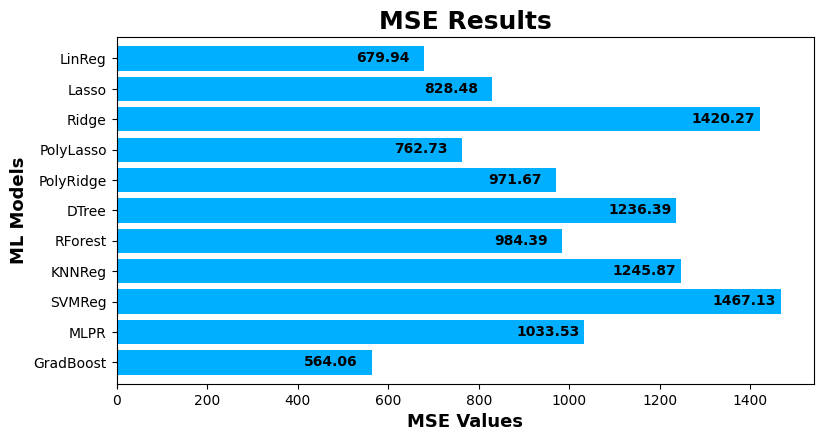

In [262]:
methods = ['LinReg', 'Lasso', 'Ridge', 'PolyLasso', 'PolyRidge', 'DTree', 'RForest', 'KNNReg', 'SVMReg',
           'MLPR', 'GradBoost']
plt.figure(figsize=(9,4.5))
plt.barh(range(11), res_mse, color='#00afff')
plt.title("MSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(11), methods)
plt.ylim(10.7,-0.7)
plt.xlabel('MSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(11):
    plt.text(res_mse[i]-150, i+0.12, "{:.2f}".format(res_mse[i]), fontweight='bold')
plt.show()

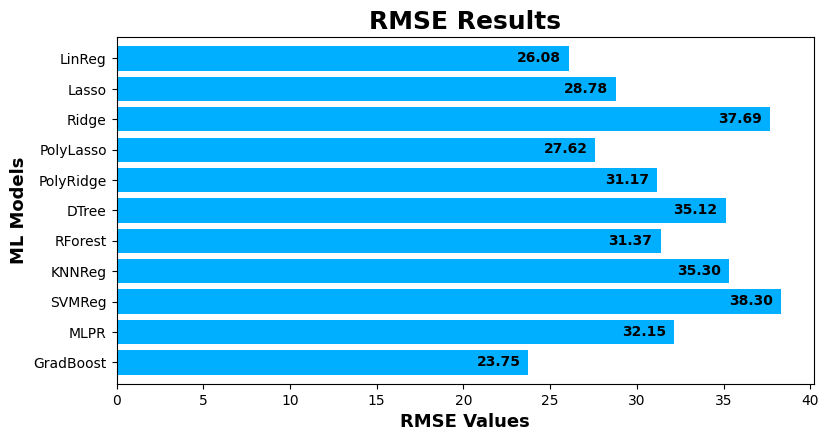

In [263]:
plt.figure(figsize=(9,4.5))
plt.barh(range(11), res_rmse, color='#00afff')
plt.title("RMSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(11), methods)
plt.ylim(10.7,-0.7)
plt.xlabel('RMSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(11):
    plt.text(res_rmse[i]-3, i+0.12, "{:.2f}".format(res_rmse[i]), fontweight='bold')
plt.show()

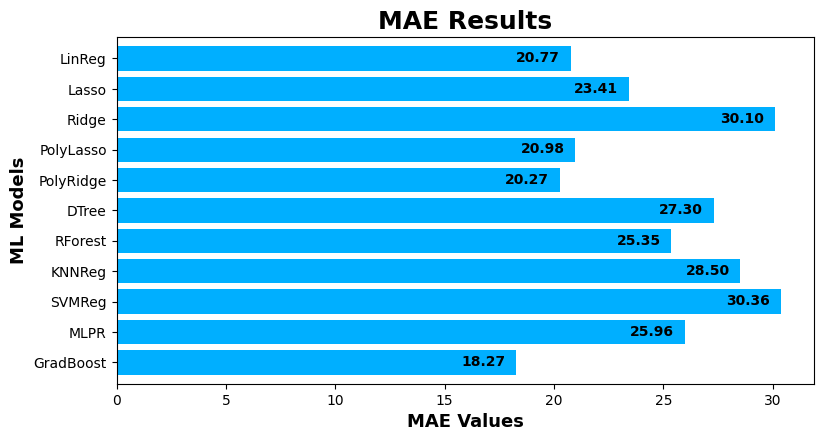

In [266]:
plt.figure(figsize=(9,4.5))
plt.barh(range(11), res_mae, color='#00afff')
plt.title("MAE Results", fontsize=18, fontweight='bold')
plt.yticks(range(11), methods)
plt.ylim(10.7,-0.7)
plt.xlabel('MAE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(11):
    plt.text(res_mae[i]-2.5, i+0.12, "{:.2f}".format(res_mae[i]), fontweight='bold')
plt.show()

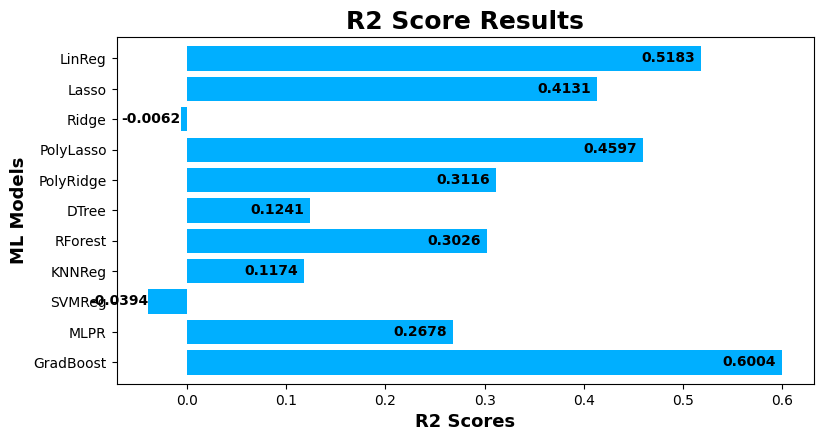

In [267]:
plt.figure(figsize=(9,4.5))
plt.barh(range(11), res_r2, color='#00afff')
plt.title("R2 Score Results", fontsize=18, fontweight='bold')
plt.yticks(range(11), methods)
plt.ylim(10.7,-0.7)
plt.xlabel('R2 Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(11):
    plt.text(res_r2[i]-0.06, i+0.12, "{:.4f}".format(res_r2[i]), fontweight='bold')
plt.show()

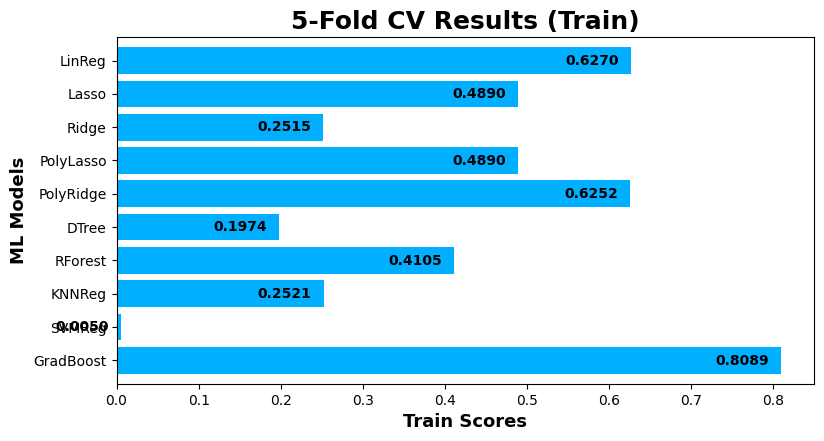

In [278]:
plt.figure(figsize=(9,4.5))
plt.barh(range(10), res_cv_train, color='#00afff')
plt.title("5-Fold CV Results (Train)", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods[:9]+[methods[10]])
plt.ylim(9.7,-0.7)
plt.xlabel('Train Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_cv_train[i]-0.08, i+0.12, "{:.4f}".format(res_cv_train[i]), fontweight='bold')
plt.show()

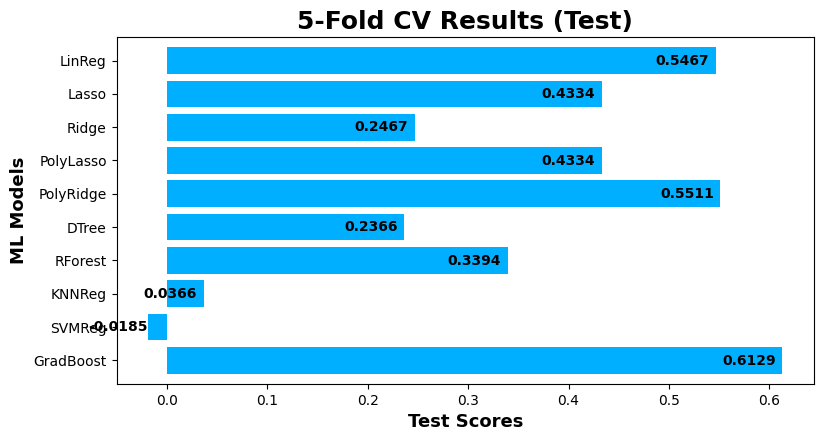

In [279]:
plt.figure(figsize=(9,4.5))
plt.barh(range(10), res_cv_test, color='#00afff')
plt.title("5-Fold CV Results (Test)", fontsize=18, fontweight='bold')
plt.yticks(range(10), methods[:9]+[methods[10]])
plt.ylim(9.7,-0.7)
plt.xlabel('Test Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(10):
    plt.text(res_cv_test[i]-0.06, i+0.12, "{:.4f}".format(res_cv_test[i]), fontweight='bold')
plt.show()